# Predictive Modeling w/ PyTorch
This notebook is a work-in-progress.

- Code to predict stock market movements with large scale technical indicator data used in PyTorch layers.
- Model choice will likely be LSTM but TBD.
- The original data is 'close' pricing and daily 'volume'. These are further extended with many technical indicators.
- The technical indicator data is then pulled for stocks that have close correlations in return with a 'given' input ticker.
- Data for several of these tickers (and their corrs) is then concatenated to construct training dataset.
- In-progress: Further fine-tuning of the initial train/test in PyTorch NN layers

REFERENCE:
- https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [1]:
import os
import os.path
from datetime import datetime
from typing import Any
import time
import numpy as np

import pandas as pd
from pandas.errors import EmptyDataError
from sqlalchemy import create_engine, text
from sklearn.preprocessing import MinMaxScaler

from functools import reduce
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
pd.options.mode.chained_assignment = None

In [2]:
# Setup
BASE_DIR = '../../../../workspace/HelloPython/HistoricalMarketData/TechnicalIndicators'
TABLE_EQUITIES_DATA = 'equities_historic_data'
DURATIONS = (14, 30, 90, 200)  # Roughly for bi-weekly, monthly, quarterly, and 200 days running averages

try:
    DB = os.environ["DB"]
    DB_USER = os.environ["DB_USER"]
    DB_PWD = os.environ["DB_PWD"]
except KeyError:
    raise Exception("Required environment variables DB_USER and DB_PWD not set")
DB_URL = 'mysql+mysqlconnector://' + DB_USER + ':' + DB_PWD + '@localhost/' + DB
ENGINE = create_engine(DB_URL)

In [3]:
def generate_file_path(symbol, date=None):
    """
    Generates a file path for a given symbol
    to retrieve calculated tech indicator data
    from local CSV records
    :param symbol: ticker
    :param date: date embedded in the file name
    :return: file name and path
    """
    if date is not None:
        str_date = datetime.strftime(date, '%Y%m%d')
        file_name = symbol.lower() + '_' + str_date + '.csv'
    else:
        file_name = symbol.lower() + '.csv'
    file_path = os.path.join(BASE_DIR, file_name)
    if file_path is None:
        print('Could not find file for symbol:{}'.format(symbol))
    # print(file_path)
    return file_path, file_name

In [4]:
def retrieve_technical_indicator_data_for_symbol(symbol, columns = None, feature=None)\
        -> Any:
    """
    Retrieves Technical Indicator Data for a given symbol
    for given columns and labels them as Y (dependent) or
    X (input features).
    :param symbol: Symbol for which to retrieve Technical Indicator Data
    :param columns: Subset of Technical Indicator Data to retrieve
    :param feature: Y or X_i label where 'i' is feature number
    :return:
    """
    file_path, _ = generate_file_path(symbol)
    if file_path is not None:
        try:
            dfrm = pd.read_csv(file_path)
            dfrm['date'] = pd.to_datetime(dfrm['date'])
            dfrm.set_index('date', inplace=True)
            dfrm.sort_index(ascending=True)
            dfrm.index.name = 'date'
            if feature is None: #Use either ticker or X_n for column header
                feature = symbol.upper()
            if columns is not None:
                dfrm = dfrm[columns] # Limit data to input columns
                dfrm.columns = [ # Label data as in 'SYMBOL_Close' versus just 'Close'
                feature.upper()+'_'+column # Or, label as 'X_1_Close' if feature is 'X_1'
                for column in dfrm.columns
                if column in columns
                ]
            else:
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                ]
            return dfrm
        except FileNotFoundError as e:
            print('Exception reading input data for symbol {}. Generating metadata starting from baseline date.'.format(symbol.upper()))
            return None
        except EmptyDataError as e:
            print(f'No technical indicators found for {symbol.upper()}. Generating metadata starting from baseline date.')
            print('Generating all records.')
            return None
    else:
        print(f"No technical indicators data in DB for '{symbol}'.")
    return None

# Test
tmp_df = retrieve_technical_indicator_data_for_symbol('AAPL', ['volume', 'close'])
tmp_df.tail(10)

,AAPL_volume,AAPL_close
date,,
2025-04-30,52286454,212.50
2025-05-01,57365675,213.32
2025-05-02,101010621,205.35
2025-05-05,69018452,198.89
2025-05-06,51216482,198.51
2025-05-07,68616943,196.25
2025-05-08,50478872,197.49
2025-05-09,36453923,198.53
2025-05-12,63775814,210.79


In [5]:
def find_symbols_w_highest_correlations(symbol, correlations, count):
    """
    Finds tickers whose return have highest correlation
    with the returns of given symbol
    :param symbol:
    :param correlations:
    :param count:
    :return:
    """
    if len(correlations[correlations['level_0'] == symbol.upper()+'_close']) <= 0:
        print("No correlations found for symbol:{}.".format(symbol.upper()))
        print("Likely data does not go far enough back.")
        return None
    corrs = correlations[correlations['level_0'] == symbol.upper()+'_close']
    corrs.sort_values(0, ascending = False, inplace = True)
    return_symbols = [symbol.replace('_close', '') for symbol in corrs.loc[:,'level_1'].tolist()]
    return return_symbols[:count]

In [6]:
def gen_corrs(dfrm):
    """
    Generate correlations numbers for entire
    input dataframe consisting of daily close values
    :param dfrm:
    :return:
    """
    correlations = dfrm[dfrm.columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    #print(correlations)`
    return correlations

## Training Dataset
Generate training dataset by finding symbols that have the highest correlation (based on daily 'close' values) with the given symbol. Then aggregate their returns over the years. The daily closing price of our target symbol becomes independent variable y and rest of the data including closing values of other symbols and their volumes make up the 'features' or 'X'.

In [7]:
MIN_ROW_COUNT = 5000 # Number of days to retrieve training data for
COMP_COUNT = 10 # Number of stocks to find high correlations with

query = 'SELECT symbol FROM equities_historic_data GROUP BY symbol HAVING COUNT(*) > '+str(MIN_ROW_COUNT)+''
with ENGINE.connect() as conn:
    res = conn.execute(text(query))
dfrm_symbols_list = pd.DataFrame(res.mappings().all())
symbols = dfrm_symbols_list['symbol'].tolist() # this is our universe of symbol tickers

# First calculate universal correlations among ALL these symbols
dfrm_list_daily_closes = list()
for symbol in symbols:
    dfrm = retrieve_technical_indicator_data_for_symbol(symbol, ['close', 'volume'])
    dfrm_list_daily_closes.append(dfrm)
merged_dfrm_daily_close_values = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_daily_closes)
correlations = gen_corrs(merged_dfrm_daily_close_values)

# Now merge a symbol's returns with returns of symbols
# it has the highest correlations with. Then stack (concat)
# all these returns across symbols to come up with our
# training dataset

# Data for a symbol and its corrs matches
# Think of this as a single line in a matrix
dfrm_list_single_row_data = list()
# Data for all symbol and their corrs matches
# Think of this as a matrix
dfrm_list_full_matrix_data = list() # Data for
tgt_symbols_list = ['JPM', 'C', 'MS', 'GS', 'WFC', 'BAC'] # Generate training data for this set only
for symbol in tgt_symbols_list:
    # Our dependent variable Y - generalize the name so we can stack up many symbols for training dataset
    dfrm_symbol = retrieve_technical_indicator_data_for_symbol(symbol, None, 'Y')
    dfrm_list_single_row_data.append(dfrm_symbol)
    symbols_w_highest_corrs = find_symbols_w_highest_correlations(symbol, correlations, COMP_COUNT)
    if symbols_w_highest_corrs is None:
        continue # Likely not enough data for a symbol. Continue with rest
    print(f'Symbols with highest correlations with {symbol.upper()} are {symbols_w_highest_corrs}')
    counter = 1
    for comp_symbol in symbols_w_highest_corrs:
        feature = 'X_'+str(counter)
        dfrm_tmp = retrieve_technical_indicator_data_for_symbol(comp_symbol, None, feature)
        dfrm_list_single_row_data.append(dfrm_tmp)
        counter += 1
    # Now merge the symbol and all its corrs data against the same date
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_single_row_data)
    dfrm_list_full_matrix_data.append(merged_df)
    dfrm_list_single_row_data.clear()
# Now concatenate data. This means dates are repeated
dfrm_aggr_training_data = pd.concat(dfrm_list_full_matrix_data)

Symbols with highest correlations with JPM are ['TXN', 'PNC', 'MAR', 'SPGI', 'SCHW', 'SIVB', 'SYK', 'WM', 'RJF', 'SNPS']
Symbols with highest correlations with C are ['AIG', 'RF', 'KEY', 'ZION', 'HIG', 'HBAN', 'ARNC', 'FITB', 'KIM', 'XRX']
Symbols with highest correlations with MS are ['HIG', 'DRE', 'ZION', 'KEY', 'FITB', 'LNC', 'MGM', 'RF', 'XRX', 'MET']
Symbols with highest correlations with GS are ['BK', 'STT', 'PRU', 'NTRS', 'CMA', 'CME', 'LNC', 'CBRE', 'SCHW', 'PFG']
Symbols with highest correlations with WFC are ['USB', 'DIS', 'PPG', 'UPS', 'SNA', 'IPG', 'OMC', 'MDLZ', 'AMGN', 'WHR']
No correlations found for symbol:BAC.
Likely data does not go far enough back.


In [8]:
dfrm_single_symbol_training_data = dfrm_list_full_matrix_data[0]
# Avoid null values
dfrm_single_symbol_training_data = dfrm_single_symbol_training_data[~dfrm_single_symbol_training_data.isnull().any(axis=1)]
dfrm_single_symbol_training_data.tail(10)

,Y_symbol,Y_close,Y_volume,Y_mean_200,Y_stddev_200,Y_pcntleStdDevs_200,Y_pcntleVolume_200,Y_pcntleClosing_200,Y_oscillator_200,Y_accu_dist_200,...,X_10_stddev_90,X_10_accu_dist_200,X_10_bollingerLower_200,X_10_bollingerUpper_200,X_10_mean_200,X_10_oscillator_200,X_10_pcntleClosing_200,X_10_pcntleStdDevs_200,X_10_pcntleVolume_200,X_10_stddev_200
date,,,,,,,,,,,,,,,,,,,,,
2023-08-11,JPM,154.45,5180690,140.468929,8.100901,52.857143,0.714286,90.000000,89.271683,9.331555e+06,...,20.624417,328766.057243,324.413290,471.941853,398.177571,68.527172,67.142857,81.428571,5.714286,36.882141
2023-08-14,JPM,154.77,5044282,140.620145,8.242251,55.072464,0.724638,89.855072,90.238743,9.575378e+06,...,18.988186,427949.369856,326.380067,472.617469,399.498768,73.919095,71.739130,78.260870,47.826087,36.559350
2023-08-15,JPM,150.83,10300303,140.698768,8.287724,55.797101,55.797101,84.782609,78.331822,6.753507e+06,...,17.247753,458313.564631,327.058951,473.099020,400.078986,75.563288,74.637681,77.536232,52.173913,36.510017
2023-08-16,JPM,150.19,6978235,140.770290,8.326927,56.521739,10.144928,84.057971,76.397703,6.290510e+06,...,15.430173,326310.991431,327.788792,473.397295,400.593043,68.142671,64.492754,76.811594,66.666667,36.402126
2023-08-17,JPM,148.63,9953912,140.826835,8.323442,56.115108,51.798561,82.014388,71.683288,5.160958e+06,...,15.094795,263245.464163,328.112648,473.411669,400.762158,64.567203,60.431655,75.539568,92.805755,36.324755
2023-08-18,JPM,148.97,8517460,140.885000,8.321955,55.714286,28.571429,82.857143,72.710789,5.394542e+06,...,14.678037,293193.946643,328.429070,473.456073,400.942571,66.237495,60.714286,75.000000,52.142857,36.256751
2023-08-21,JPM,149.48,8327018,140.976087,8.411650,58.695652,25.362319,82.608696,74.252040,5.786369e+06,...,13.870644,447707.946260,330.107756,474.207462,402.157609,74.786629,73.913043,70.289855,26.086957,36.024927
2023-08-22,JPM,146.38,9681972,141.030000,8.422340,59.420290,46.376812,77.536232,64.883651,3.546520e+06,...,12.516317,445501.597965,330.596677,474.701149,402.648913,74.715505,73.188406,70.289855,33.333333,36.026118
2023-08-23,JPM,147.37,7858021,141.075507,8.439615,60.869565,20.289855,78.260870,67.875491,4.249986e+06,...,11.133535,634662.868130,331.159687,475.396110,403.277899,85.250711,85.507246,71.739130,50.724638,36.059106


## Data Normalization and Train-Test split

In [9]:
# Start with separating features (independent vector matrix X) and dependent vector (y)
batch_size = 5
len_data = len(dfrm_single_symbol_training_data)
tgt_field_column_name = 'Y_close'
tgt_symbol_column_name = 'Y_symbol'
train_to_total_ratio = 0.8

p = int(train_to_total_ratio * dfrm_single_symbol_training_data.shape[0])
# The train and test dataset must be perfect multiple of batch size
p = p - p % batch_size # Align train set length to batch size
q = dfrm_single_symbol_training_data.shape[0] - p
q = q - q % batch_size # Align test set length to batch size
dfrm_training = dfrm_single_symbol_training_data[:p]
dfrm_test = dfrm_single_symbol_training_data[p:p+q] # Last few test samples are skipped
print(len(dfrm_training))
print(len(dfrm_test))

4065
1015


In [10]:
# x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'symbol' not in column] # Use all numerical features including technical indicators
x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'close' in column] # Only use daily close values for training
Y_train = dfrm_training[tgt_field_column_name]
X_train = dfrm_training[x_columns]
# Drop null values - didn't see major upside in results. Commented out
# null_indices = X_train[X_train.isnull().any(axis=1)].index
# X_train = X_train.drop(null_indices)
# Y_train = Y_train.drop(null_indices)

Y_test = dfrm_test[tgt_field_column_name]
X_test = dfrm_test[x_columns]

# Scale the target variable
scaler_y = MinMaxScaler(feature_range=(-1, 1))
transformed_Y_train = scaler_y.fit_transform(Y_train.values.reshape(-1,1))
transformed_Y_test = scaler_y.transform(Y_test.values.reshape(-1,1))

# Scale the features
scaler_x = MinMaxScaler(feature_range=(-1, 1))
transformed_X_train = scaler_x.fit_transform(X_train)
transformed_X_test = scaler_x.transform(X_test)

In [11]:
x_train = torch.from_numpy(transformed_X_train).to(torch.float32)
x_test = torch.from_numpy(transformed_X_test).to(torch.float32)
y_train = torch.from_numpy(transformed_Y_train).to(torch.float32)
y_test = torch.from_numpy(transformed_Y_test).to(torch.float32)

# Create a dataset and data loader for features (X) and label (y)
train_dataset = TensorDataset(x_train.unsqueeze(1), y_train)  # Add sequence dimension
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(x_test.unsqueeze(1), y_test)  # Add sequence dimension
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
x_train.shape

torch.Size([4065, 10])

In [13]:
# Dimensions for data input
input_dim = len(X_train.columns) # Number of features
#hidden_dim = int(len(X_train)) # Number of samples or units
hidden_dim = 512
num_layers = 2
output_dim = 1
num_epochs = 5 # Intentionally keeping low for initial debugging
seq_len = 10

## Model Definition and Predictions

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bn = torch.nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(0.1)

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure x has batch dimension
        #print("Input size:", x.size(0))
        # print(f'X:{x}')
        x = self.dropout(x)
        # x = self.bn(x) # Batch normalization didn't help with results
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [15]:

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers= num_layers, output_dim=output_dim, )
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.lstm

LSTM(10, 512, num_layers=2, batch_first=True)

## Model Training and Evaluation

In [16]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    counter = 1
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.reshape(5, -1, input_dim)
        y_train_pred = model(x_batch)
        loss = criterion(y_train_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if counter % 100 == 0:
            print(f'Epoch:{t:}, Batch:{counter}, Loss: {loss.item():.4f}')
        counter += 1
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch:0, Batch:100, Loss: 0.0358
Epoch:0, Batch:200, Loss: 0.0214
Epoch:0, Batch:300, Loss: 0.0663
Epoch:0, Batch:400, Loss: 0.0082
Epoch:0, Batch:500, Loss: 0.0339
Epoch:0, Batch:600, Loss: 0.0003
Epoch:0, Batch:700, Loss: 0.0034
Epoch:0, Batch:800, Loss: 0.2552
Epoch:1, Batch:100, Loss: 0.0209
Epoch:1, Batch:200, Loss: 0.0371
Epoch:1, Batch:300, Loss: 0.3437
Epoch:1, Batch:400, Loss: 0.0033
Epoch:1, Batch:500, Loss: 0.0250
Epoch:1, Batch:600, Loss: 0.0061
Epoch:1, Batch:700, Loss: 0.0287
Epoch:1, Batch:800, Loss: 0.4264
Epoch:2, Batch:100, Loss: 0.0159
Epoch:2, Batch:200, Loss: 0.0202
Epoch:2, Batch:300, Loss: 0.1168
Epoch:2, Batch:400, Loss: 0.0220
Epoch:2, Batch:500, Loss: 0.0283
Epoch:2, Batch:600, Loss: 0.0088
Epoch:2, Batch:700, Loss: 0.0086
Epoch:2, Batch:800, Loss: 0.1916
Epoch:3, Batch:100, Loss: 0.0090
Epoch:3, Batch:200, Loss: 0.0153
Epoch:3, Batch:300, Loss: 0.0741
Epoch:3, Batch:400, Loss: 0.0061
Epoch:3, Batch:500, Loss: 0.0048
Epoch:3, Batch:600, Loss: 0.0042
Epoch:3, B

### LSTM Predictions

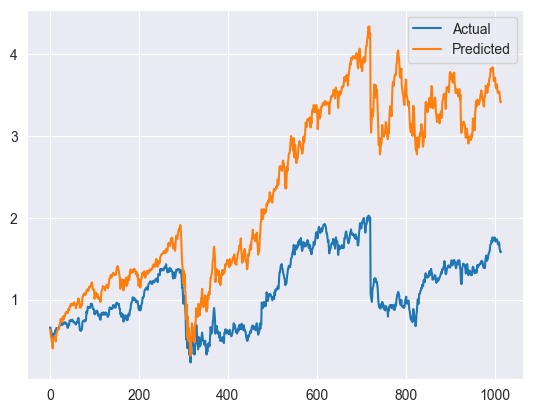

In [17]:
# Make predictions on the test dataset
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        test_labels.extend(labels.cpu().numpy().flatten()) # Add observed values to list
        inputs = inputs.reshape(5, -1, input_dim)
        outputs = model(inputs)
        test_preds.extend(outputs.cpu().numpy().flatten()) # Add predicted values to list

# Plot predictions against actual values
plt.plot(test_labels, label='Actual')
plt.plot(test_preds, label='Predicted')
plt.legend()
plt.show()


### GRU

In [18]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.1)

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [19]:
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.00001)
model_gru.gru


GRU(10, 512, num_layers=2, batch_first=True)

In [20]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    counter = 1
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.reshape(5, -1, input_dim)
        y_train_pred = model_gru(x_batch)
        loss = criterion(y_train_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if counter % 100 == 0:
            print(f'Epoch:{t:}, Batch:{counter}, Loss: {loss.item():.4f}')
        counter += 1
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch:0, Batch:100, Loss: 0.1616
Epoch:0, Batch:200, Loss: 0.0418
Epoch:0, Batch:300, Loss: 0.0979
Epoch:0, Batch:400, Loss: 0.0213
Epoch:0, Batch:500, Loss: 0.0103
Epoch:0, Batch:600, Loss: 0.0071
Epoch:0, Batch:700, Loss: 0.0085
Epoch:0, Batch:800, Loss: 0.2744
Epoch:1, Batch:100, Loss: 0.0169
Epoch:1, Batch:200, Loss: 0.0033
Epoch:1, Batch:300, Loss: 0.0170
Epoch:1, Batch:400, Loss: 0.0050
Epoch:1, Batch:500, Loss: 0.0077
Epoch:1, Batch:600, Loss: 0.0009
Epoch:1, Batch:700, Loss: 0.0003
Epoch:1, Batch:800, Loss: 0.0441
Epoch:2, Batch:100, Loss: 0.0190
Epoch:2, Batch:200, Loss: 0.0097
Epoch:2, Batch:300, Loss: 0.0208
Epoch:2, Batch:400, Loss: 0.0058
Epoch:2, Batch:500, Loss: 0.0064
Epoch:2, Batch:600, Loss: 0.0004
Epoch:2, Batch:700, Loss: 0.0070
Epoch:2, Batch:800, Loss: 0.0045
Epoch:3, Batch:100, Loss: 0.0213
Epoch:3, Batch:200, Loss: 0.0092
Epoch:3, Batch:300, Loss: 0.0154
Epoch:3, Batch:400, Loss: 0.0063
Epoch:3, Batch:500, Loss: 0.0073
Epoch:3, Batch:600, Loss: 0.0029
Epoch:3, B

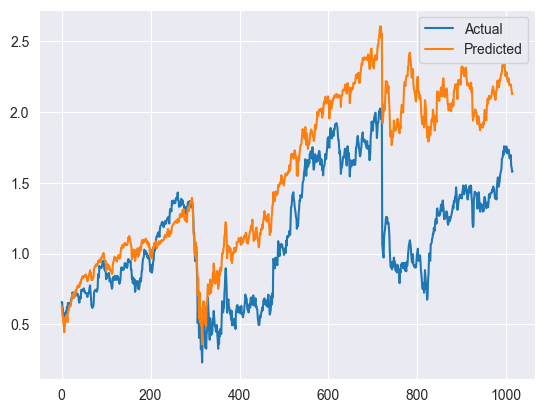

In [21]:
# Make predictions on the test dataset
model_gru.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        test_labels.extend(labels.cpu().numpy().flatten()) # Add observed values to list
        inputs = inputs.reshape(5, -1, input_dim)
        outputs = model_gru(inputs)
        test_preds.extend(outputs.cpu().numpy().flatten()) # Add predicted values to list

# Plot predictions against actual values
plt.plot(test_labels, label='Actual')
plt.plot(test_preds, label='Predicted')
plt.legend()
plt.show()


In [22]:
# torch.save(model.state_dict(), "model_lstm.pth")
# print("Saved PyTorch LSTM Model State to model_lstm.pth")
#
# torch.save(model_gru.state_dict(), "model_gru.pth")
# print("Saved PyTorch GRU Model State to model_gru.pth")

Saved PyTorch LSTM Model State to model_lstm.pth
Saved PyTorch GRU Model State to model_gru.pth


## Takeaways
- The learning rate defined as part of optimizer made the most significant difference in this case. The lr of 0.01 essentially resulted in a flat line. We had better results at 1e10-4 and in that region. Further lowering it worsened the test results.
- Training for more epochs is not improving the model in limited tests.
- GRU is performing better than LSTM. Both are directionally right but miss the extent of move at crucial junctures which is resulting in parallel lines between osberved and predicted values versus prediction overlaying observed.